<a href="https://colab.research.google.com/github/navneetkrc/Recommender_systems/blob/master/music_recommenders/hybrid_lightfm_music_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import dependencies

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse as sp
from sklearn.metrics import pairwise as pw


In [0]:
!pip install lightfm

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score, reciprocal_rank

In [0]:
sns.set()
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [0]:
"""Recommendation Class for popularity based model"""

#Class for Popularity based Recommender System model
class popularity_recommender():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

        #Get a count of user_ids for each unique song as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
    
        #Sort the songs based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(10)
    
    #Use the popularity based recommender system model to
    #make recommendations
    def recommend(self, user_id):    
        user_recommendations = self.popularity_recommendations
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id
    
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]
        
        return user_recommendations


In [0]:
"""Define some useful functions for personalized hybrid recommendation model"""

#Function to create a user dictionary based on their index and number in interaction dataset
def create_user_dict(interactions):
  user_id = list(interactions.index)
  user_dict = {}
  counter = 0 
  
  for i in user_id:
    user_dict[i] = counter
    counter += 1
    
  new_dict = dict([(value, key) for key, value in user_dict.items()])
    
  return new_dict
  
#Function to create an item dictionary based on their item_id and item name  
def create_item_dict(df, id_col, name_col):
  item_dict ={}
    
  for i in range(df.shape[0]):
    item_dict[(df.loc[i, id_col])] = df.loc[i, name_col]
        
  return item_dict

#Function to produce user recommendations
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict, threshold = 0, nrec_items = 10, show = True):
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x, np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id, :] \
                                 [interactions.loc[user_id, :] > threshold].index) \
								 .sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0: nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    
    if show == True:
        print("Recommended songs for UserID:", user_id)
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1
            
    return return_score_list


In [0]:
#Function to create item-item distance embedding matrix
def create_item_emdedding_distance_matrix(model, interactions):
    
    df_item_norm_sparse = sp.csr_matrix(model.item_embeddings)
    similarities = pw.cosine_similarity(df_item_norm_sparse)
    item_emdedding_distance_matrix = pd.DataFrame(similarities)
    item_emdedding_distance_matrix.columns = interactions.columns
    item_emdedding_distance_matrix.index = interactions.columns
    
    return item_emdedding_distance_matrix

#Function to create item-item recommendation
def item_item_recommendation(item_emdedding_distance_matrix, item_id, item_dict, n_items = 10, show = True):
    
    recommended_items = list(pd.Series(item_emdedding_distance_matrix.loc[item_id,:]. \
                                  sort_values(ascending = False).head(n_items+1). \
                                  index[1:n_items+1]))
    
    if show == True:
        print("Song of interest: {0}".format(item_dict[item_id]))
        print("Song(s) similar to the above item are as follows:-")
        counter = 1
        
        for i in recommended_items:
            print(str(counter) + '. ' +  item_dict[i])
            counter+=1
            
    return recommended_items


In [0]:

triplets = 'https://static.turi.com/datasets/millionsong/10000.txt'
songsData = 'https://static.turi.com/datasets/millionsong/song_data.csv'

rawData1 = pd.read_table(triplets, header=None)
rawData1.columns = ['user_id', 'song_id', 'listen_count']
rawData2 =  pd.read_csv(songsData)

#Create a new copy of the triplets dataset & change user_ids from string format to indexed values for easier computations
rawData1_userIndexed = rawData1.copy()
rawData1_userIndexed.user_id = rawData1.index + 1

#Merge the triplets data (user indexed) with songs data
rawData = pd.merge(rawData1_userIndexed, rawData2.drop_duplicates(['song_id']), on="song_id", how="left")

#Create a subset of top fifty thousand observations to work with, as the entire dataset is TOO expensive to compute on!!!
rawData = rawData.head(50000)

print(rawData.head())
print('\n', rawData.tail())
print('\n', rawData.describe(include='all'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """


   user_id             song_id  listen_count            title  \
0        1  SOAKIMP12A8C130995             1         The Cove   
1        2  SOBBMDR12A8C13253B             2  Entre Dos Aguas   
2        3  SOBXHDL12A81C204C0             1         Stronger   
3        4  SOBYHAJ12A6701BF1D             1   Constellations   
4        5  SODACBL12A8C13C273             1     Learn To Fly   

                         release    artist_name  year  
0             Thicker Than Water   Jack Johnson     0  
1            Flamenco Para Niños  Paco De Lucia  1976  
2                     Graduation     Kanye West  2007  
3              In Between Dreams   Jack Johnson  2005  
4  There Is Nothing Left To Lose   Foo Fighters  1999  

        user_id             song_id  listen_count  \
49995    49996  SOBRFPG12A8AE4837D             1   
49996    49997  SOBSIFR12A6D4F8560             1   
49997    49998  SOBVTVL12A8C1422D7             2   
49998    49999  SOBXOWJ12A6D4F85BA             1   
49999    50


                                                   title  listen_count  \
6421                                      Sehr kosmisch           204   
8186                                               Undo           182   
8909                                     You're The One           181   
1846                     Dog Days Are Over (Radio Edit)           173   
6100                                            Revelry           166   
6410                                            Secrets           158   
3214  Horn Concerto No. 4 in E flat K495: II. Romanc...           134   
2427                                          Fireflies           128   
7968                                           Tive Sim           117   
3109                                   Hey_ Soul Sister           109   

      percentage  
6421    0.001983  
8186    0.001322  
8909    0.000661  
1846    0.000661  
6100    0.001322  
6410    0.000661  
3214    0.000661  
2427    0.000661  
7968    0.001983  
3109

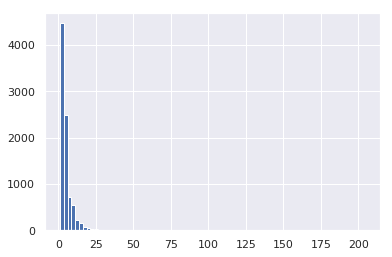

In [0]:
data = rawData.groupby(['title']).agg({'listen_count': 'count'}).reset_index()
data['percentage'] = rawData['listen_count'].div(rawData.listen_count.sum())*100
print('\n', data.sort_values(by=['listen_count'], ascending=False).head(10))

print(data['listen_count'].hist(bins=80))

users = rawData['user_id'].unique()


In [0]:
"""Popularity model"""

popModel = popularity_recommender()
popModel.create(rawData, 'user_id', 'title')
#popModel.create(trainData, 'user_id', 'artist_name') for popularity based recommendations by artists
print('\n', popModel.recommend(users[342]))





       user_id                                              title  score  Rank
6421      343                                      Sehr kosmisch    204   1.0
8186      343                                               Undo    182   2.0
8909      343                                     You're The One    181   3.0
1846      343                     Dog Days Are Over (Radio Edit)    173   4.0
6100      343                                            Revelry    166   5.0
6410      343                                            Secrets    158   6.0
3214      343  Horn Concerto No. 4 in E flat K495: II. Romanc...    134   7.0
2427      343                                          Fireflies    128   8.0
7968      343                                           Tive Sim    117   9.0
3109      343                                   Hey_ Soul Sister    109  10.0


In [0]:
"""Create Interaction Matrix"""

#Create pivot table (interaction matrix) from the original dataset
x = rawData.pivot_table(index='user_id', columns='song_id', values='listen_count')
xNan = x.fillna(0)
interaction = sp.csr_matrix(xNan.values)
print(interaction)

"""Personlized hybrid model"""

hybridModel = LightFM(loss='warp-kos', n=20, k=20, learning_schedule='adadelta')
hybridModel.fit(interaction, epochs=30, num_threads=6)


  (0, 140)	1.0
  (1, 383)	2.0
  (2, 689)	1.0
  (3, 702)	1.0
  (4, 1115)	1.0
  (5, 1161)	5.0
  (6, 1436)	1.0
  (7, 1927)	1.0
  (8, 2075)	1.0
  (9, 2847)	1.0
  (10, 3322)	1.0
  (11, 3326)	5.0
  (12, 3535)	1.0
  (13, 3555)	1.0
  (14, 3960)	5.0
  (15, 4255)	1.0
  (16, 4546)	6.0
  (17, 4617)	1.0
  (18, 4717)	1.0
  (19, 5095)	1.0
  (20, 5347)	1.0
  (21, 5606)	1.0
  (22, 6075)	1.0
  (23, 6088)	1.0
  (24, 6100)	1.0
  :	:
  (49975, 4023)	50.0
  (49976, 4406)	2.0
  (49977, 4484)	9.0
  (49978, 4980)	5.0
  (49979, 5186)	1.0
  (49980, 5297)	2.0
  (49981, 6150)	6.0
  (49982, 6277)	1.0
  (49983, 6790)	2.0
  (49984, 6859)	1.0
  (49985, 7632)	7.0
  (49986, 7682)	3.0
  (49987, 8250)	6.0
  (49988, 8637)	2.0
  (49989, 8936)	5.0
  (49990, 9294)	5.0
  (49991, 104)	4.0
  (49992, 239)	1.0
  (49993, 551)	1.0
  (49994, 564)	3.0
  (49995, 613)	1.0
  (49996, 630)	1.0
  (49997, 676)	2.0
  (49998, 693)	1.0
  (49999, 833)	1.0


In [0]:
"""Evaluation of the trained model"""

print('\nPrecision at K:', precision_at_k(hybridModel, interaction, k=15).mean().round(3)*100)
print('Recall at K:', recall_at_k(hybridModel, interaction, k=500).mean().round(3)*100)
print('Area under ROC curve:', auc_score(hybridModel, interaction).mean().round(3)*100)
print('Reciprocal Rank:', reciprocal_rank(hybridModel, interaction).mean().round(3)*100)

"""Recommendaing songs personally based on the user"""

#Creating user dictionary based on their index and number in the interaction matrix using recsys library
userDict = create_user_dict(interactions=x)
#print('\n', userDict)

#Creating a song dictionary based on their songID and artist name
songDict = create_item_dict(df=rawData, id_col='song_id', name_col='title')
#print('\n', songDict)

#Recommend songs using lightfm library
print('\n', sample_recommendation_user(model = hybridModel, interactions = x, user_id = 234, user_dict = userDict, item_dict = songDict, threshold = 5, nrec_items = 10,
                                      show = True))

#Recommend songs similar to a given songID
songItemDist = create_item_emdedding_distance_matrix(model=hybridModel, interactions=x)
print('\n\n', item_item_recommendation(item_emdedding_distance_matrix = songItemDist, item_id = 'SOSRCCU12A67ADA089',
                                    item_dict = songDict, n_items = 10))


Precision at K: 4.899999871850014
Recall at K: 91.8
Area under ROC curve: 98.00000190734863
Reciprocal Rank: 36.399999260902405
Recommended songs for UserID: 234
1- Kryptonite
2- Cosmic Love
3- In My Place
4- Twilight Galaxy
5- Check On It
6- Le Jardin d'Hiver
7- The Saltwater Room
8- Una Confusion
9- Put Your Head On My Shoulder (Album Version)
10- Can't Fight This Feeling

 ['SOLLNTU12A6701CFDC', 'SOXWYZP12AF72A42A6', 'SOMRYYN12A6310F0F3', 'SOHHSYJ12AB017F40A', 'SOKXYUW12A8C140229', 'SOMCMKG12A8C1347BF', 'SOBABSR12A58A7AD93', 'SOWGCMN12A8C136E44', 'SOALPQQ12A6701F302', 'SOICRPT12A8C13190A']
Song of interest: Fergalicious
Song(s) similar to the above item are as follows:-
1. Blue Moon
2. One More Chance (Album Version)
3. Pearl Vision
4. You Make Me Wanna...
5. Jungle Gym
6. From Left To Right
7. Tocame
8. Strength Of The World (Album Version)
9. So Com Voce
10. Chapter Four


 ['SOMYETD12A6D4F8541', 'SOCELOZ12A58A76797', 'SODYVNX12A8C1444E0', 'SOOVKMQ12AF72A71CC', 'SODOUTP12A6D4F6AA